# Inverse graphics using graphics-based generative models and MCMC

## A sidenote on the installation of the necessary pacakges for this lab:
Don't run this code (I'm not even sure if you can; there may be permission issues), 
but we are including it to show how we installed mitsuba3 in our environment
which is by using a Conda. If you want, you can follow a similar recipe to install 
it on your local.

```julia
using Pkg
Pkg.activate("myenv")
Pkg.add("Conda")
using Conda
Conda.pip("install", "mitsuba")

```

In [1]:
using Pkg
Pkg.activate("myenv")
using Distributions
using ProgressMeter
using Gen, Plots
using Parameters
using PyCall
numpy = pyimport("numpy")

  Activating project at `~/Algorithms-of-the-Mind/labs/lab-05/myenv`


PyObject <module 'numpy' from '/opt/julia/conda/3/x86_64/lib/python3.10/site-packages/numpy/__init__.py'>

## Part 0: The task

The task in this lab is to build a probabilistic inverse graphics model: The model will go from a 2D image to a 3D scene inference (aka single-image 3D reconstruction). We will do so by inverting a graphics-based generative model of images.  

## Part 1
## Mini introduction to computer graphics

Computer graphics are concerned with algorithmically tractable methods for representing 3D scenes (static or dynamic) and syntesizing realistic (or non-realistic) imagery based off of these scenes. Rendering is the process of synthesizing an image from a 3D (or a 2D) scene via a computer program. We will refer to such computer programs as *rendering engines*.

<img src="./images/render.png" alt="" width="400"/>

In a rendering engine, a 3D scene is defined by 4 basic ingredients:

* Objects (e.g., 3D shapes and surfaces)
* Optical material properties (how the surface of an object is supposed to reflect light; e.g., glass-like, diffuse, opaque, transparent, shiny, etc.)
* Lights
* Sensors or camera

This course is obviously not about developing rendering engines -- see the relevant courses offered by the Department of Computer Science and numerous resources online. Instead, we will program existing rendering engines, embedding them within probabilistic models.

To program a rendering engine to create a 3D scene and project it to an image, all you need to do is to provide a description of these four elements.

## Mini introduction to Mitsuba3

The field of computer graphics developed many algorithms for realistic image synthesis. At the highest level, rendering engines can be categorized into two: rasterization- vs. physically-based rendering. 

Mitsuba3 is a physically-based graphics renderer. This means that it sends "rays" from the camera out into the scene and tracks where and how they intersect light sources. These rays are then integrated to figure out what color to paint on each pixel in an image. 

<img src="./images/raytracing.png" alt="" width="400"/>

Like other rendering engines, we need to input to mitsuba3 a scene (lights, optical materials, objects, sensory). This can be done using an XML file or a python dictionary. We provide examples of both below. 

In this course, we chose to work with mitsuba3 because it is open source software, and has some exciting attributes (many of which we will not get into in this lab), including differentiable rendering capabilities. In addition, in ongoing research in Ilker's lab, mitsuba3 proved dependable for its numerical stability and customizability for probabilistic inference. 

Please see the [tutorials](https://www.youtube.com/watch?v=9Ja9buZx0Cs&list=PLI9y-85z_Po6da-pyTNGTns2n4fhpbLe5) and [documentation](https://mitsuba.readthedocs.io/en/stable/) on Mitsuba3's [official website](https://www.mitsuba-renderer.org/) for more. 

Notice that mitsuba3 is a python package; to use it we rely on the `PyCall` package of Julia, which provides a native interface to python code. You can familiarize yourself with PyCall [here](https://github.com/JuliaPy/PyCall.jl#usage).

## Part 2

## Getting started with mitsuba3 

In this tutorial, we will learn about how to load a scene and render it. Mitsuba3 gives a lot of fun flexibility, especially in terms of rendering. 

Before we start, let's execute our very first command with mitsuba3.

In [2]:
# import mitsuba using pycall
mi = pyimport("mitsuba")

# different rendering modes of mitsuba 
# for our purposes, we wish to highlight the differentiable vs. scalar modes
mi.variants()

4-element Vector{String}:
 "scalar_rgb"
 "scalar_spectral"
 "cuda_ad_rgb"
 "llvm_ad_rgb"

Now the output of this function `mi.variants()` tells us that mitsuba3 can render a scene in 4 different modes. We will be using the `scalar_rgb` mode in this lab, which will render a standard RGB image.

However, we note that mitsuba3 is a differentiable renderer, and this functionality can only be utilized in the `cuda_ad_rgb` and `llbm_ad_rgb` modes, which we do not explore in this lab. See mitsuba3 documentation and tutorials for this advanced topic.

### Loading and rendering a scene (objects, lights, materials, sensors) in mitsuba3

Here we will first set our mode of rendering to be `scalar_rgb`.

Then, we will load a scene with with two cuboids in a room with differently colored walls. We will then render it.

The scene description will be loaded from a python dictionary based on an example from the mitsuba3 gallery. Run this code and review its output to appreciate how it defines each of the four kinds of elements we are talking about: shapes, lights, optical materials (jargon name: BSDFs), and sensors.

`OBJMesh` are the walls, `Sphere` is a shape; things like `SmoothDiffuse` are optical material properties; `emitter`s are lights; and `PerspectiveCamera` is the sensor. Notice how each entry has certain properties: For example an object needs to define where it is in the world (`to_world`) and its optical material property.

You can also review `cbox-generic.xml` under this folder to again appreciate what goes into a scene.

In [3]:
mi.set_variant("scalar_rgb")

@pyinclude("./cbox-generic.py")

scene_d = py"initialize_scene()"o::PyObject

# load the scene using the load_dict function
scene::PyObject = @pycall mi.load_dict(scene_d)::PyObject

PyObject Scene[
  children = [
    OBJMesh[
      name = "cbox_back.obj",
      bbox = BoundingBox3f[
        min = [-1, -1, -1],
        max = [1, 1, -1]
      ],
      vertex_count = 4,
      vertices = [96 B of vertex data],
      face_count = 2,
      faces = [24 B of face data],
      face_normals = 0
    ],
    OBJMesh[
      name = "cbox_ceiling.obj",
      bbox = BoundingBox3f[
        min = [-1, 1, -1],
        max = [1, 1, 1]
      ],
      vertex_count = 4,
      vertices = [96 B of vertex data],
      face_count = 2,
      faces = [24 B of face data],
      face_normals = 0
    ],
    TwoSided[
      brdf[0] = SmoothDiffuse[
        reflectance = SRGBReflectanceSpectrum[
          value = [0.725, 0.71, 0.68]
        ]
      ],
      brdf[1] = SmoothDiffuse[
        reflectance = SRGBReflectanceSpectrum[
          value = [0.725, 0.71, 0.68]
        ]
      ]
    ],
    OBJMesh[
      name = "cbox_floor.obj",
      bbox = BoundingBox3f[
        min = [-1, -1, -1],
        ma

Remember that we mentioned mitsuba3 is a physically-based renderer that estimates the color of each pixel using ray tracing. Ray-tracing is a computationally costly operation and mitsuba3 allows you to make a tradeoff that suits your goals. 

The parameter `spp`, which stands for samples per pixel and is input to the `mi.render` function below, is essentially the number of rays cast to compute the color per pixel. The choice of spp reflects a tradeoff: The greater the spp, the higher the quality and realism of our render is, at the expense of computational cost. You can reduce spp to obtain lower quality renders, which is often acceptable, especially for characterizing an approximate process of rendering that may be implemented in the mind and brain. (Regardless, this will be handy when we are doing probabilistic inference later on.) 

In [4]:
# set spp to 12 -- play with different values
spp::Int32 = 128

# render the scene
image = @pycall mi.render(scene, spp=spp)::PyObject
# get the bitmap, which Jupyter notebook displays inline!
bitmap = @pycall mi.Bitmap(image).convert(srgb_gamma=true)::PyObject

PyObject Bitmap[
  pixel_format = rgb,
  component_format = float32,
  size = [64, 64],
  srgb_gamma = 1,
  struct = Struct<12>[
    float32 R; // @0, gamma, premultiplied alpha
    float32 G; // @4, gamma, premultiplied alpha
    float32 B; // @8, gamma, premultiplied alpha
  ],
  data = [ 48 KiB of image data ]
]

Wow! How cool is that?! You just rendered a nice scene with umm spheres in it. Yay for you! 

### Transformations of scene elements using mitsuba3

Now a critical component of computer graphics is to manipulate the scene -- including adding, deleting, changing, moving (translating) and scaling the things in a scene. Here we will learn how we can translate and scale one of the cuboids in the scene. 

There are multiple ways in which one can transform the scene elements. See this mitsuba3 [tutorial](https://mitsuba.readthedocs.io/en/stable/src/rendering/editing_a_scene.html) for an approach we will not use in this lab.

The approach we will take is to update the dictionary that contains the scene configuration -- `scene_d` using mitsuba3's [transformation library](https://mitsuba.readthedocs.io/en/stable/src/how_to_guides/transformation_toolbox.html#Transform). 

We will transform the sphere on the right -- `right-object`. 

Let's first see the entry for `right-object` in `scene_d` dictionary.

In [5]:
println(get(scene_d, "right-object", true))

Dict{Any, Any}("to_world" => PyObject [[0.5, 0, 0, 0.5],
 [0, 0.5, 0, -0.75],
 [0, 0, 0.5, -0.2],
 [0, 0, 0, 1]], "rightobject-bsdf" => Dict{Any, Any}("id" => "color-sphere", "type" => "ref"), "type" => "sphere")


The PyObject which is a 4x4 quantity is a combined transformation consisting of the size of the object and where it is. 

Scale: `[[0.5, 0, 0], [0, 0.5, 0], [0.0, 0, 0.5]]`

Translation: `[0.5, -0.75, -0.2]`

Let's assign a new size and modify the z-coordinate of its location.

In [6]:
object = "right-object"
# create a new transformation
translation = [0.5, -0.75, 0.7]
scale = 0.25 # we will make it a cube

# now create the transformation using mi's transformation toolbox
t = @pycall mi.Transform4f.translate(translation).scale(scale)::PyObject
lb = PyObject(get(scene_d, object))
set!(lb, "to_world", t)
set!(scene_d, object, lb)

PyObject {'to_world': [[0.25, 0, 0, 0.5],
 [0, 0.25, 0, -0.75],
 [0, 0, 0.25, 0.7],
 [0, 0, 0, 1]], 'rightobject-bsdf': {'id': 'color-sphere', 'type': 'ref'}, 'type': 'sphere'}

Now let's reload this updated dictionary into our scene and render it.

In [7]:
# load the scene using the load_dict function
scene::PyObject = @pycall mi.load_dict(scene_d)::PyObject
image = @pycall mi.render(scene, spp=spp)::PyObject
# get the bitmap, which Jupyter notebook displays inline!
bitmap = @pycall mi.Bitmap(image).convert(srgb_gamma=true)::PyObject

PyObject Bitmap[
  pixel_format = rgb,
  component_format = float32,
  size = [64, 64],
  srgb_gamma = 1,
  struct = Struct<12>[
    float32 R; // @0, gamma, premultiplied alpha
    float32 G; // @4, gamma, premultiplied alpha
    float32 B; // @8, gamma, premultiplied alpha
  ],
  data = [ 48 KiB of image data ]
]

Notice how the right object became smaller than it was before and came closer to the sensor.

In [26]:
# to avoid a bug...
scene = 1

1

Okay now let's do some *inverse* graphics.

## Part 3

## Inverse graphics

We start by writing a Julia struct to hold the state of the scene -- including the path, the mitsuba3 scene, and the spp. 

In [10]:
# the with_kw macro comes from the Parameters package 
# and is a handy macro for having default values to certain entries in a Julia struct.
@with_kw struct ModelParams
    scene_d::PyDict
    scene::PyObject = @pycall mi.load_dict(scene_d)::PyObject
    spp::Int32 = 16
end

ModelParams

As further setup, let's also include the python file (included in this folder) that contains the scene configuration we will work with.

In [11]:
mi = pyimport("mitsuba")
mi.set_variant("scalar_rgb")
@pyinclude("./cbox-generic.py")

We will also define helper functions for 

* transformations (moving and scaling objects)
* rendering

In [12]:
function mitsuba_transform(scene_d, object, scale, translation)
    t = @pycall mi.Transform4f.translate(translation).scale(scale)::PyObject
    lb = PyObject(get(scene_d, object))
    set!(lb, "to_world", t)
    set!(scene_d, object, lb)
    return scene_d
end

function mitsuba_render(modelparams)
    image = @pycall mi.render(modelparams.scene, spp=modelparams.spp)::PyObject
    bitmap = @pycall mi.Bitmap(image).convert(srgb_gamma=true)::PyObject
    mu = @pycall numpy.array(bitmap)::Array{Float32, 3}
    mu[:, :, 1]
end

function mitsuba_render_bitmap(modelparams)
    image = @pycall mi.render(modelparams.scene, spp=modelparams.spp)::PyObject
    bitmap = @pycall mi.Bitmap(image).convert(srgb_gamma=true)::PyObject
end

mitsuba_render_bitmap (generic function with 1 method)

### Generative model

Now we will proceed with writing our generative model. 

The generative model will define a distribution over *images* parametrized by a scene configuration, a renderer, and the size of the objects in it. 

To keep things pedagogically tractable, the generative model will make a few assumptions. The generative model will assume that there are two objects in the scene -- two spheres (otherwise, the scene configuration will be the same room as above) --, the knowledge of where these spheres are, and the knowledge of the viewpoint (where the sensor is). Notice that you can relax each of these assumptions with appropriate prior distributions! 

The generative model will define priors over the sizes of the spheres. 

And the generative model will define a gaussian likelihood function (a la Erdogan & Jacobs, 2017) over images. 

The generative model will use a much cheaper rendering protocol by setting `spp=16` (instead of 128, which is what we will use to render the observation). This will mimick the default scenario where the internal representation can get by with much coarser processes than reality.

In [13]:
@gen function room()

    # load the scene configuration, including a room with colored walls, two spheres, lights, materials, and a sensor
    scene_d = py"initialize_scene()"o::PyObject
    
    # prior over the scale of the left sphere
    s_left ~ uniform(0.1, 1.0)
    # we assume we know a priori where this sphere will appear in the scene
    t_left = [-0.3, -0.5, 0.2]
    # transform the object in the scene according to this scale and translation parameters
    scene_d = mitsuba_transform(scene_d, "left-object", s_left, t_left)
    
    # prior over the scale of the right sphere
    s_right ~ uniform(0.1, 1.0)
    # we assume we know a priori where this sphere will appear in the scene
    t_right = [0.5, -0.75, -0.2] 
    # transform the object in the scene according to this scale and translation parameters
    scene_d = mitsuba_transform(scene_d, "right-object", s_right, t_right)

    # load the resulting scene into our struct
    # Notice that we are using a much cheaper spp for inference
    modelparams = ModelParams(scene_d=scene_d, spp=16)

    # render into an array
    mu = mitsuba_render(modelparams)

    # define the likelihood as a gaussian with diagonal covariance
    pred ~ broadcasted_normal(mu, 1.0)

end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}[], var"##room#292", Bool[], false)

We define a helper function `view_image` to render and visualize scenes using mitsuba3

In [14]:
function view_image(t)
    scene_d = py"initialize_scene()"o::PyObject
    t_left = [-0.3, -0.5, 0.2]
    mitsuba_transform(scene_d, "left-object", t[:s_left], t_left)
    
    t_right = [0.5, -0.75, -0.2] 
    mitsuba_transform(scene_d, "right-object", t[:s_right], t_right)
    #scene = mi.load_dict(scene_d)
    scene_to_render = ModelParams(scene_d=scene_d)
    bitmap = mitsuba_render_bitmap(scene_to_render)
end

view_image (generic function with 1 method)

Now we are ready to draw a sample from this generative model and visualize

In [15]:
# draw a random sample from the generative model
trace = Gen.simulate(room, ())
get_choices(trace)

│
├── :s_left : 0.6785536465946741
│
├── :pred : [-1.31907289571017 0.7791934920025652 -1.061643265868601 1.058523452840781 -0.5594256540088378 0.14022692902695683 -0.8298824485302423 -1.276798867200272 1.3467618029171244 1.247593772073236 0.0803963781396032 0.1658703622597976 -1.1444984950949841 0.9240093490081582 -1.209093716643557 0.5509492510466822 -1.5703687239441293 2.0001298761520614 0.4872618013415548 1.1426034446929143 0.9889647775835302 0.27713236992398627 0.38400513954472865 0.5588864583958014 0.03320615587089222 -0.7058722586182554 0.033031858717232215 -1.1756591730099835 0.21181388218441816 -1.1591689377440546 -0.2431931179669883 0.5264853518483845 -1.583306922824027 -0.45206796694936746 -0.3968806121810132 0.49525904436868995 -2.795490979944993 -2.19207492721117 0.8407205091108418 0.675040386697261 -1.3648682775376693 0.7937017257135985 0.36840035341928984 -0.6458243915944005 0.8238215850370464 0.07000275558047572 0.20916595346109057 -1.0557487952197815 -0.012206789621032

In [16]:
view_image(trace)

PyObject Bitmap[
  pixel_format = rgb,
  component_format = float32,
  size = [64, 64],
  srgb_gamma = 1,
  struct = Struct<12>[
    float32 R; // @0, gamma, premultiplied alpha
    float32 G; // @4, gamma, premultiplied alpha
    float32 B; // @8, gamma, premultiplied alpha
  ],
  data = [ 48 KiB of image data ]
]

Now let's load a scene from mitsuba3's gallery and render it as our observed image

In [28]:
# load the scene from an xml file (instead of a dict)
obs_scene_config = mi.load_file("./scenes/cbox.xml")
obs_scene = ModelParams(scene_d = PyDict(), scene = obs_scene_config, spp=128)
obs_bitmap = mitsuba_render_bitmap(obs_scene)
obs_image = Gen.choicemap()
p = @pycall numpy.array(obs_bitmap)::Array{Float64, 3}
obs_image[:pred] = p[:, :, 1]
# again, hoping to avoid that nasty bug...
obs_scene = 1
# to view the image on your notebook
obs_bitmap

PyObject Bitmap[
  pixel_format = rgb,
  component_format = float32,
  size = [64, 64],
  srgb_gamma = 1,
  struct = Struct<12>[
    float32 R; // @0, gamma, premultiplied alpha
    float32 G; // @4, gamma, premultiplied alpha
    float32 B; // @8, gamma, premultiplied alpha
  ],
  data = [ 48 KiB of image data ]
]

### Inference: Random walk MH

We will implement a simple random walk MH procedure. In particular, we will make (truncated) gaussian proposals over the sizes of each of the two spheres in the scene. Otherwise, this is super off-the-shelf MCMC code in Gen.

In [19]:
# include the truncated norm distribution
include("truncatednorm.jl")

Define proposals for perturbing the two latent variables in the generative model

In [20]:
# proposal distribution for the scale variables
@gen function scale_proposal(current_trace)
    # trunc_norm(mean, std, lower_bound, upper_bound)
    # why do we need a truncated norm, instead of a regular normal distribution?
    s_left ~ trunc_norm(current_trace[:s_left], 0.15, 0.1, 1.)
    s_right ~ trunc_norm(current_trace[:s_right], 0.15, 0.1, 1.)
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any], false, Union{Nothing, Some{Any}}[nothing], var"##scale_proposal#293", Bool[0], false)

The inference procedure couldn't really get any simpler: Make MH moves on the two latents and that's all.

In [21]:
function random_walk_mh(tr)
    # make a random-walk update on scale variables
    (tr, accepted) = mh(tr, scale_proposal, ())

    # return the updated trace
    tr
end

random_walk_mh (generic function with 1 method)

Now call this inference procedure in an iterative loop -- notice that we are going for a rather small number of iterations -- `K=50` -- let's see if this works!

In [22]:
function do_inference()
    K = 50
    t, = generate(room, (), obs_image)
    scores = Vector{Float64}(undef, K)
    @showprogress for i in 1:K
        t = random_walk_mh(t)
        scores[i] = get_score(t)
    end;
    return scores, t
end

do_inference (generic function with 1 method)

In [23]:
# call the inference procedure
(scores, t) = do_inference()

Progress: 100%|█████████████████████████████████████████| Time: 0:00:15


([-3878.8286532467223, -3843.6719673406856, -3824.884939756912, -3816.343622123084, -3816.343622123084, -3816.343622123084, -3816.343622123084, -3816.343622123084, -3810.5340436570928, -3809.349076223732  …  -3787.2440070251414, -3787.2440070251414, -3787.2440070251414, -3787.2440070251414, -3787.2440070251414, -3787.2440070251414, -3787.2440070251414, -3787.2440070251414, -3787.2440070251414, -3787.2440070251414], Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}[], var"##room#292", Bool[], false), Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}(:s_left => Gen.ChoiceOrCallRecord{Float64}(0.5037726787654069, 0.10536051565782628, NaN, true), :pred => Gen.ChoiceOrCallRecord{Matrix{Float64}}([0.0 0.0 … 0.0 0.0; 0.0 0.000747780897654593 … 0.005403640680015087 0.0; … ; 0.0 0.005634177941828966 … 0.005745545029640198 0.0; 0.0 0.0 … 0.0 0.0], -3787.454728056457, NaN, true)

Now, how do I know if my inference procedure worked? 

Let's first visualize to see if our log likelihood scores improved over iterations (x-axis: iterations; y-axis: log scores).

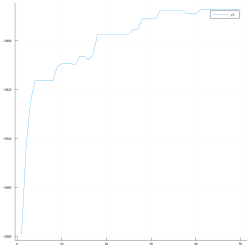

In [24]:
plot(scores, size = (1000, 1000))

Alright this should look good. Try to reason about how often proposals are accepted by the step-wise changes in the loglikelihood scores over iterations.

Now let's find out what our inferred scene looks like at the end of the procedure:

In [25]:
view_image(t)

PyObject Bitmap[
  pixel_format = rgb,
  component_format = float32,
  size = [64, 64],
  srgb_gamma = 1,
  struct = Struct<12>[
    float32 R; // @0, gamma, premultiplied alpha
    float32 G; // @4, gamma, premultiplied alpha
    float32 B; // @8, gamma, premultiplied alpha
  ],
  data = [ 48 KiB of image data ]
]

Compare the image that your model synthesized to what the observation was like from above. Did the inference procedure work reasonably well? Try changing the number of iterations. 

## Taking stock:

Notice what we have accomplished: The result of the inference procedure is not just a reconstructed image -- rather, it is a causal explanation that goes far beyond what was in the image: a 3D scene that we can re-light, re-pose, and manipulate. The result of inference